# OpenAPS IOB Calculations
----

This notebook will replicate and visualize the calculation of Insulin On Board (`iob`) used in the [OpenAPS project](https://github.com/openaps/oref0).

Specifically, it will replicate the javascript code found in [oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/master/lib/iob/calculate.js) and plot the `iob` curves for a set of Duration of Insulin Activity (`dia`) values.

### First, some definitions:
* **dia:** Duration of Insulin Activity. This is the user specified time (in hours) that insulin lasts in their body after a bolus. This value comes from the user's pump settings. (Not sure whether Medtronic places any limits when setting this value. Testing here assumes integers between 2 and 8 hours.)


* **end:** Duration (in minutes) that insulin is active. end = dia * 60.


* **peak:** Duration (in minutes) when insulin action it's peak activity level.

    **Key Assumption #1:** Given a default value of 3 hours for `dia`, which translates into 180 minutes for `end`, assume that `peak` insulin activity ocurrs between 60 and 90 minutes after dosage. As such, the OpenAPS algorithm assumes that insulin activity peaks at 75 minutes for a `dia` of 3 hours. This assumption is generalizable to other user `dia` settings. That is, `peak` can be expressed as a function of `dia` by multiplying by the ratio (75 / 180):
    
    `peak` = f(`dia`) = (`dia` \* 60 \* (75 / 180))
    
    So, for example, for a `dia` of 4 hours, `peak` will be at 100 minutes:
    
    100 = (4 \* 60 \* (75 / 180))


* **activity:** This is the variable name used in OpenAPS to represent "portion of insulin that was active in the previous minute." 

    **Key Assumption #2:** Activity increases linearly until the `peak` and then decreases linearly (at a slightly slower rate) until the `end`.

    **Note:** The code in [oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/master/lib/iob/calculate.js) doesn't actually calculate a variable called `activity`. Instead, it calculates a variable called `activityContrib`, which is I've broken into its two components: `activity` and `treatment.insulin`. I analyze `activity`, which is just the scaling factor applied to `treatment.insulin`.

Two examples of IOB curves:

Here: [http://journals.sagepub.com/doi/pdf/10.1177/193229680900300319](http://journals.sagepub.com/doi/pdf/10.1177/193229680900300319)

and

Here: [https://www.hindawi.com/journals/cmmm/2015/281589/](https://www.hindawi.com/journals/cmmm/2015/281589/)




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Coefficients used in estimating the percent of insulin remaining, or (alternatively) the insulin action/decay curve.
# Coeff[0] = alpha * 1
# Coeff[1] = beta1 * x^2
# Coeff[2] = beta2 * x
insulin_action_coeffs = [[1.000000, -0.001852, 0.001852],   # Applied between [0,peak)
                         [0.555560, 0.001323, -0.054233]]   # Applied between [peak,end]
# Source: ?????

In [3]:
def calc_IOB(dia):
    
    peak = 75
    end = 180
    
    x_list = []
    iob_list = [] 
    act_list = []
    
    for i_min in range(0, dia * 60):
        
        if (i_min > 0):
            i_min_minus1 = i_min - 1
        else:
            i_min_minus1 = i_min
            
        i_min = i_min * 3.0 / dia
        i_min_minus1 = i_min_minus1 * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1 # Why + 1? Should there be a (i_min == 0) condition that returns iob_pct = 1?
            x_list.append(x)
            
            # Calculation used in OpenAPS
            iob_pct = (insulin_action_coeffs[0][0] + insulin_action_coeffs[0][1] * x**2 + insulin_action_coeffs[0][2] * x)
            iob_list.append(iob_pct)
            
            x_minus1 = (i_min_minus1 / 5) + 1
            
            # Calculation of 'activity' based on IOBt-1 - IOBt
            act = (insulin_action_coeffs[0][0] + insulin_action_coeffs[0][1] * x_minus1**2 + insulin_action_coeffs[0][2] * x_minus1) - iob_pct
            act_list.append(act)
            
        elif (i_min < end):
            x = (i_min - peak) / 5 # Also, why / 5? Is this just b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            
            iob_pct = insulin_action_coeffs[1][0] + insulin_action_coeffs[1][1] * x**2 + insulin_action_coeffs[1][2] * x
            iob_list.append(iob_pct)

            x_minus1 = (i_min_minus1 - peak) / 5 
            
            act = (insulin_action_coeffs[1][0] + insulin_action_coeffs[1][1] * x_minus1**2 + insulin_action_coeffs[1][2] * x_minus1) - iob_pct
            act_list.append(act)
    
    return x_list, iob_list, act_list   

In [4]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # NB: range() ends at n-1
    x_list, iob_list, act_list = calc_IOB(dia)
    iob_df = pd.DataFrame({'x' : x_list, 'iob_pct_dia_' + str(dia) : iob_list, 'activity_dia_' + str(dia) : act_list})
    dict_of_dfs_by_dia.update({dia : iob_df})

In [31]:
dict_of_dfs_by_dia[3].head()

,activity_dia_3,iob_pct_dia_3,x
0,0.000000,1.000000,1.0
1,0.000444,0.999556,1.2
2,0.000593,0.998963,1.4
3,0.000741,0.998222,1.6
4,0.000889,0.997333,1.8


In [32]:
dict_of_dfs_by_dia[3].tail()

,activity_dia_3,iob_pct_dia_3,x
175,0.000316,0.000100,20.0
176,0.000210,-0.000110,20.2
177,0.000104,-0.000214,20.4
178,-0.000002,-0.000212,20.6
179,-0.000108,-0.000104,20.8


In [34]:
dict_of_dfs_by_dia[3].iloc[61, :]

activity_dia_3     0.009334
iob_pct_dia_3      0.701754
x                 13.200000
Name: 61, dtype: float64

In [35]:
dict_of_dfs_by_dia[3].iloc[121, :]

activity_dia_3    0.006031
iob_pct_dia_3     0.168595
x                 9.200000
Name: 121, dtype: float64

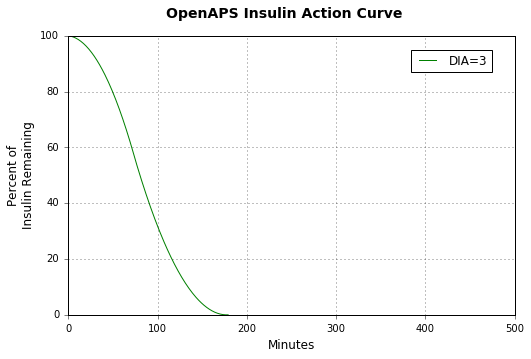

In [14]:
# Now plot the curves
plt.figure(figsize=(8, 5))

plt.ylabel('Percent of\nInsulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Insulin Action Curve', fontsize=14, fontweight='bold')

iob_pct_3 = dict_of_dfs_by_dia[3]['iob_pct_dia_3'] * 100
iob_pct_3.plot(kind='line', label='DIA=3', color='g').grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5)

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

#plt.savefig('OpenAPS_insulin_action_curves_dia_3.png', format='png', dpi=600)

plt.xlim([0,500])
plt.ylim([0,100])

plt.show()   

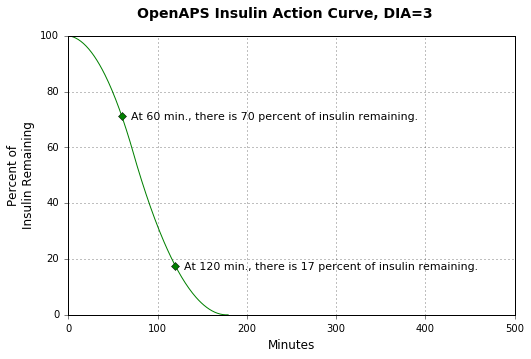

In [38]:
plt.figure(figsize=(8, 5))

plt.ylabel('Percent of\nInsulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Insulin Action Curve, DIA=3', fontsize=14, fontweight='bold')

iob_pct_3 = dict_of_dfs_by_dia[3]['iob_pct_dia_3'] * 100
markers = [60, 120]
iob_pct_3.plot(kind='line', label='DIA=3', color='g', markevery=markers, marker='D').grid(True)

plt.text(70, 70, 'At 60 min., there is 70 percent of insulin remaining.' , fontsize=11)
plt.text(130, 16, 'At 120 min., there is 17 percent of insulin remaining.' , fontsize=11)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5)

#plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

plt.savefig('OpenAPS_insulin_action_curves_dia_3.png', format='png', dpi=600)

plt.xlim([0,500])
plt.ylim([0,100])

plt.show()   


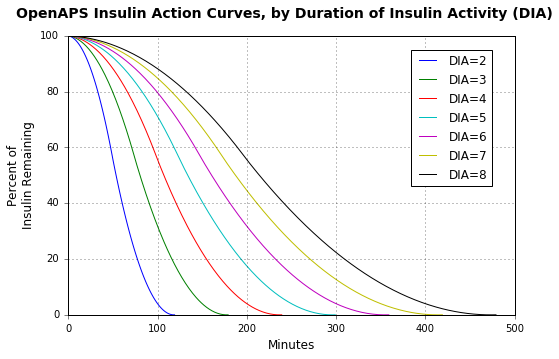

In [39]:
# Now plot the curves
plt.figure(figsize=(8, 5))

plt.ylabel('Percent of\nInsulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Insulin Action Curves, by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    (dict_of_dfs_by_dia[dia]['iob_pct_dia_' + dia_str]*100).plot(kind='line', label='DIA=' + dia_str).grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5)    
    
plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

plt.xlim([0,500])
plt.ylim([0,100])

plt.savefig('OpenAPS_insulin_action_curves_by_dia.png', format='png', dpi=600)

plt.show()   

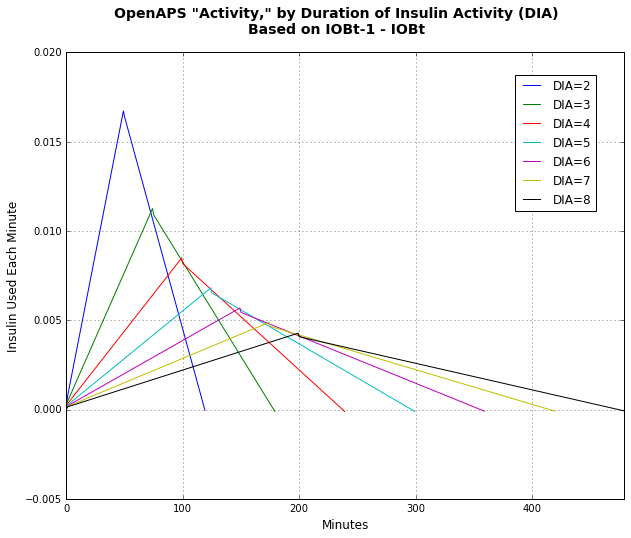

In [359]:
# Plot insulin activity curves based on IOBt-1 - IOBt caclculation
plt.figure(figsize=(10, 8))

plt.ylabel('Insulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)\nBased on IOBt-1 - IOBt', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['activity_dia_' + str(dia)].plot(kind='line', label='DIA=' + dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)
plt.savefig('OpenAPS_activity_by_dia_2.png', format='png', dpi=600)

plt.show()   